In [1]:
import cv2 as cv
from os import listdir
import preprocess_lego_image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
tf.config.list_physical_devices('GPU')

Matplotlib created a temporary cache directory at /tmp/matplotlib-ua6pk7h6 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2024-05-19 20:53:40.623736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 20:53:41.894083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-19 20:53:41.897935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Note that manually loading and examining the data was an interesting exercise. However, I recently learned about the Keras built-in method [load_data_set_from_directory](https://keras.io/api/preprocessing/image/) that can probably replace a lot of the code below.
[The Keras transfer learning documentation](https://keras.io/guides/transfer_learning/#an-endtoend-example-finetuning-an-image-classification-model-on-a-cats-vs-dogs-dataset) has a nice example that could be used as a guideline for refactoring this.

In [2]:
data_dir_labeled = '/data/labeled'
labels = listdir(data_dir_labeled)
labels.sort()
labels

['15712tile1x1withopenoclip', '3023plate1x2', '43857liftarmthick1x2']

In [5]:
def load_data():
    data = []
    for label in labels:
        label_path = f'{data_dir_labeled}/{label}'
        image_paths = listdir(label_path)
        for image_path in image_paths:                
            image = preprocess_lego_image.preprocess(f'{label_path}/{image_path}')
            data.append([label, image])
    return data

labeled_data = load_data()

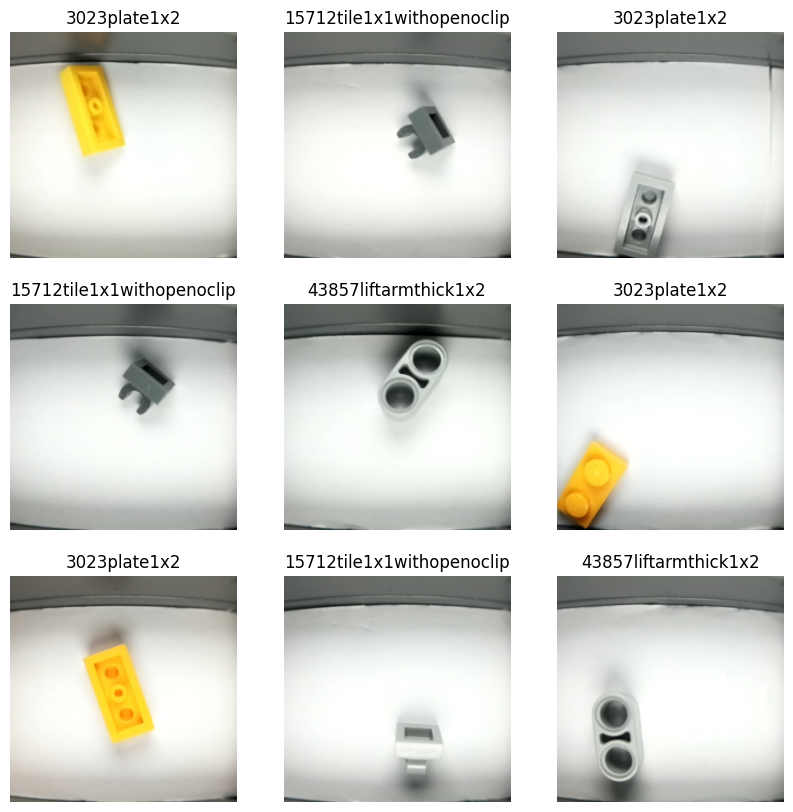

In [6]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis("off")
    i = i + 1

In [7]:
df = pd.DataFrame(labeled_data,columns = ['label','image'])
data_train = df.sample(frac=0.8, random_state=1)
data_test = df.drop(data_train.index)
print(f'# training data: {len(data_train)}')
print(f'# training data: {len(data_test)}')

# training data: 465
# training data: 116


In [8]:
from tensorflow.keras.utils import to_categorical
X_train = np.array(data_train.drop(['label'], axis=1))
y_train = to_categorical(np.array(data_train['label'].apply(lambda l: labels.index(l))))
X_test = np.array(data_test.drop(['label'], axis=1))
y_test = to_categorical(np.array(data_test['label'].apply(lambda l: labels.index(l))))

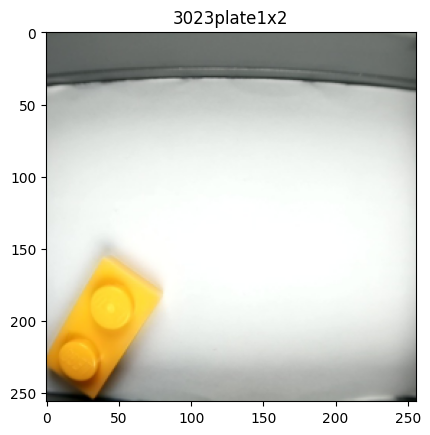

In [14]:
#sanity check
random_index = random.randint(0, len(X_train) - 1)
plt.title(labels[np.argmax(y_train[random_index])])
plt.imshow(cv.cvtColor(X_train[random_index][0], cv.COLOR_BGR2RGB))

In [15]:
L = []
for k in X_train:
    L += [k[0]]
L = np.array(L)
X_train = L
X_train.shape

(465, 256, 256, 3)

In [16]:
P = []
for k in X_test:
    P += [k[0]]
P = np.array(P)
X_test = P
X_test.shape

(116, 256, 256, 3)

In [17]:
X_test[0].shape

(256, 256, 3)

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
X_test = preprocess_input(X_test)
X_train = preprocess_input(X_train)
X_test.shape

(116, 256, 256, 3)

In [19]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg16.trainable = False
vgg16.summary()

2024-05-19 20:57:56.194342: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-19 20:57:56.194463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-19 20:57:56.194492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-19 20:57:56.337486: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-19 20:57:56.337544: I external/local_xla/xla/stream_executor

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
model = tf.keras.models.Sequential()
model.add(vgg16)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(len(labels), activation='softmax'))

In [21]:
#model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [22]:
model.build([None, 256, 256, 3])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,558,467 (120.39 MB)

 Trainable params: 16,843,779 (64.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=200, verbose=1)

Epoch 1/50


I0000 00:00:1716152313.705534     132 service.cc:145] XLA service 0x7fa6a0004530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716152313.705578     132 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-05-19 20:58:33.724771: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-19 20:58:33.827573: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1716152314.847225     207 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_724', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1716152314.915195     209 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_724', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1716

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.3150 - loss: 0.4201

I0000 00:00:1716152342.055139     319 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1289', 84 bytes spill stores, 72 bytes spill loads

I0000 00:00:1716152342.058635     334 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_724', 212 bytes spill stores, 124 bytes spill loads

I0000 00:00:1716152342.234456     332 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1289', 128 bytes spill stores, 128 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3161 - loss: 0.4265   

I0000 00:00:1716152355.428764     490 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_208', 420 bytes spill stores, 252 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 59s 15s/step - accuracy: 0.3166 - loss: 0.4298 - val_accuracy: 0.3276 - val_loss: 0.4462
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.3562 - loss: 0.4210 - val_accuracy: 0.4138 - val_loss: 0.3552
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.4212 - loss: 0.3560 - val_accuracy: 0.5345 - val_loss: 0.2707
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.5636 - loss: 0.2603 - val_accuracy: 0.4138 - val_loss: 0.3608
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.3876 - loss: 0.3834 - val_accuracy: 0.4224 - val_loss: 0.3665
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.4900 - loss: 0.3094 - val_accuracy: 0.5862 - val_loss: 0.2605
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.5805 - loss: 0.2634 - val_accuracy: 0.6207 - val_loss: 0.2333
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.7116 - loss: 0.1622 - val_accuracy: 0.7672 - val_loss: 0.1283
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


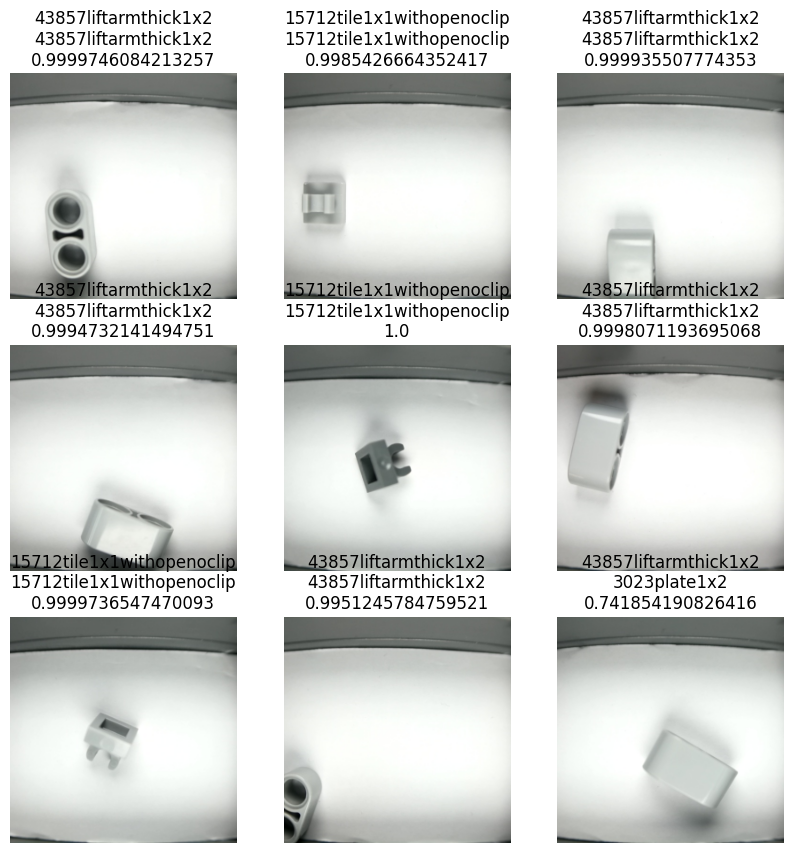

In [26]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    expected_label, example_image = random.sample(labeled_data, 1)[0]
    prediction = model.predict(preprocess_input(np.array([example_image])))
    most_likely = np.argmax(prediction)
    predicted_label = labels[most_likely]
    predicted_prob = prediction[0][most_likely]
    plt.title(f'{expected_label}\n{predicted_label}\n{predicted_prob}')
    plt.imshow(cv.cvtColor(example_image, cv.COLOR_BGR2RGB))
    plt.axis("off")
    i = i + 1

In [27]:
# fine tuning
vgg16.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [28]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=1)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 991ms/step - accuracy: 0.9983 - loss: 8.0198e-04 - val_accuracy: 0.8879 - val_loss: 0.0525
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.9983 - loss: 9.6335e-04 - val_accuracy: 0.8793 - val_loss: 0.0536
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.9970 - loss: 0.0018 - val_accuracy: 0.8879 - val_loss: 0.0540
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.9983 - loss: 9.7304e-04 - val_accuracy: 0.8879 - val_loss: 0.0534
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.9970 - loss: 0.0018 - val_accuracy: 0.8879 - val_loss: 0.0525
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.9970 - loss: 0.0018 - val_accuracy: 0.8879 - val_loss: 0.0518
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.9983 - loss: 9.7219e-04 - val_accuracy: 0.8879 - val_loss: 0.0512
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.9989 - loss: 0.0017 - val_accuracy: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


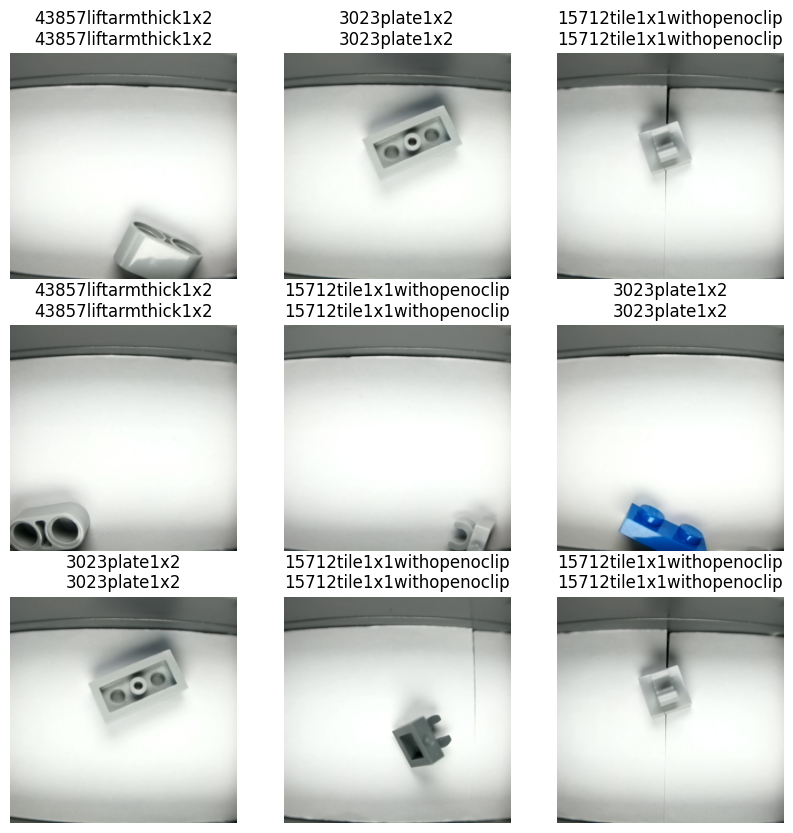

In [30]:
plt.figure(figsize=(10, 10))
i = 0
for label, image in random.sample(labeled_data, 9):
    ax = plt.subplot(3, 3, i + 1)
    expected_label, example_image = random.sample(labeled_data, 1)[0]
    prediction = model.predict(preprocess_input(np.array([example_image])))
    np.argmax(prediction)
    predicted_label = labels[np.argmax(prediction)]
    plt.title(f'{expected_label}\n{predicted_label}')
    plt.imshow(cv.cvtColor(example_image, cv.COLOR_BGR2RGB))
    plt.axis("off")
    i = i + 1

In [ ]:
model.save('model.keras')